In [1]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
import sys
sys.path.append('/content/drive/MyDrive/AttSets-master')


TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
'''@inProceedings{Yang18b,
  title={Robust Attentional Aggregation of Deep Feature Sets for Multi-view 3D Reconstruction},
  author = {Bo Yang
  and Sen Wang
  and Andrew Markham
  and Niki Trigoni,
  booktitle={IJCV 2019},
  year={2018}
  }'''
import tensorflow as tf
import data_loader as tools
import sys
import os
import scipy.io
import shutil
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt

batch_size = 4
img_res = 127
vox_res32 = 32
total_mv = 24
GPU0 = '0'
re_train=False

single_view_train = False
multi_view_train = False


config={}
config['batch_size'] = batch_size
config['total_mv'] = total_mv
config['cat_names'] = ['03001627']
for name in config['cat_names']:
    config['X_rgb_'+name] = '/content/drive/MyDrive/3D_reconstruction/Data_sample/Dataset/'+name+'/'
    config['Y_vox_'+name] = '/content/drive/MyDrive/3D_reconstruction/Data_sample/Original_3D_model/'+name+'/'


def attsets_fc(x, out_ele_num,  name):
	in_ele_num = tf.shape(x)[1]
	in_ele_len = int(x.get_shape()[2])
	out_ele_len = in_ele_len
	

	x_1st = x
	x_1st_tp = tf.reshape(x_1st, [-1, in_ele_len])
	weights_1st = tools.Ops.fc(x_1st_tp, out_d=out_ele_num*out_ele_len, name=name+'_1st')	


	weights_1st = tf.reshape(weights_1st, [-1, in_ele_num, out_ele_num, out_ele_len])
	weights_1st = tf.nn.softmax(weights_1st, 1)
	x_1st = tf.tile(x_1st[:,:,None,:], [1,1,out_ele_num,1])
	x_1st = x_1st*weights_1st
	x_1st = tf.reduce_sum(x_1st, axis=1)
	x_1st = tf.reshape(x_1st, [-1, out_ele_num*out_ele_len])

	return x_1st, weights_1st

In [4]:
class Network:
	def __init__(self):
		self.train_mod_dir = './train_mod/'
		self.train_sum_dir = './train_sum/'
		self.test_res_dir = './test_res/'
		self.test_sum_dir = './test_sum/'
		
		print ('re_train:', re_train)
		if os.path.exists(self.test_res_dir):
			if re_train:
				print ('test_res_dir and files kept!')
			else:
				shutil.rmtree(self.test_res_dir)
				os.makedirs(self.test_res_dir)
				print ('test_res_dir: deleted and then created!')
		else:
			os.makedirs(self.test_res_dir)
			print ('test_res_dir: created!')
		
		if os.path.exists(self.train_mod_dir):
			if re_train:
				if os.path.exists(self.train_mod_dir + 'model.cptk.data-00000-of-00001'):
					print ('model found! will be reused!')
				else:
					print ('model not found! error!')
					#exit()
			else:
				shutil.rmtree(self.train_mod_dir)
				os.makedirs(self.train_mod_dir)
				print ('train_mod_dir: deleted and then created!')
		else:
			os.makedirs(self.train_mod_dir)
			print ('train_mod_dir: created!')
		
		if os.path.exists(self.train_sum_dir):
			if re_train:
				print ('train_sum_dir and files kept!')
			else:
				shutil.rmtree(self.train_sum_dir)
				os.makedirs(self.train_sum_dir)
				print ('train_sum_dir: deleted and then created!')
		else:
			os.makedirs(self.train_sum_dir)
			print ('train_sum_dir: created!')
		
		if os.path.exists(self.test_sum_dir):
			if re_train:
				print ('test_sum_dir and files kept!')
			else:
				shutil.rmtree(self.test_sum_dir)
				os.makedirs(self.test_sum_dir)
				print ('test_sum_dir: deleted and then created!')
		else:
			os.makedirs(self.test_sum_dir)
			print ('test_sum_dir: created!')

	def base_r2n2(self, X_rgb):
		im_num = tf.shape(X_rgb)[1]
		[_, _, d1, d2, cc] = X_rgb.get_shape()
		X_rgb = tf.reshape(X_rgb, [-1, int(d1), int(d2), int(cc)])

		en_c = [96, 128, 256, 256, 256, 256]
		l1 = tools.Ops.xxlu(tools.Ops.conv2d(X_rgb, k=7, out_c=en_c[0], str=1, name='l1'), label='lrelu')
		l2 = tools.Ops.xxlu(tools.Ops.conv2d(l1, k=3, out_c=en_c[0], str=1, name='l2'), label='lrelu')
		l2 = tools.Ops.maxpool2d(l2, k=2, s=2, name='l2_p')

		l3 = tools.Ops.xxlu(tools.Ops.conv2d(l2, k=3, out_c=en_c[1], str=1, name='l3'), label='lrelu')
		l4 = tools.Ops.xxlu(tools.Ops.conv2d(l3, k=3, out_c=en_c[1], str=1, name='l4'), label='lrelu')
		l22 = tools.Ops.conv2d(l2, k=1, out_c=en_c[1], str=1, name='l22')
		l4 = l4 + l22
		l4 = tools.Ops.maxpool2d(l4, k=2, s=2, name='l4_p')

		l5 = tools.Ops.xxlu(tools.Ops.conv2d(l4, k=3, out_c=en_c[2], str=1, name='l5'), label='lrelu')
		l6 = tools.Ops.xxlu(tools.Ops.conv2d(l5, k=3, out_c=en_c[2], str=1, name='l6'), label='lrelu')
		l44 = tools.Ops.conv2d(l4, k=1, out_c=en_c[2], str=1, name='l44')
		l6 = l6 + l44
		l6 = tools.Ops.maxpool2d(l6, k=2, s=2, name='l6_p')

		l7 = tools.Ops.xxlu(tools.Ops.conv2d(l6, k=3, out_c=en_c[3], str=1, name='l7'), label='lrelu')
		l8 = tools.Ops.xxlu(tools.Ops.conv2d(l7, k=3, out_c=en_c[3], str=1, name='l8'), label='lrelu')
		l8 = tools.Ops.maxpool2d(l8, k=2, s=2, name='l8_p')

		l9 = tools.Ops.xxlu(tools.Ops.conv2d(l8, k=3, out_c=en_c[4], str=1, name='l9'), label='lrelu')
		l10 = tools.Ops.xxlu(tools.Ops.conv2d(l9, k=3, out_c=en_c[4], str=1, name='l10'), label='lrelu')
		l88 = tools.Ops.conv2d(l8, k=1, out_c=en_c[4], str=1, name='l88')
		l10 = l10 + l88
		l10 = tools.Ops.maxpool2d(l10, k=2, s=2, name='l10_p')

		l11 = tools.Ops.xxlu(tools.Ops.conv2d(l10, k=3, out_c=en_c[5], str=1, name='l11'), label='lrelu')
		l12 = tools.Ops.xxlu(tools.Ops.conv2d(l11, k=3, out_c=en_c[5], str=1, name='l12'), label='lrelu')
		l1010 = tools.Ops.conv2d(l10, k=1, out_c=en_c[5], str=1, name='l1010_p')
		l12 = l12 + l1010
		l12 = tools.Ops.maxpool2d(l12, k=2, s=2, name='l12_p')

		[_, d1, d2, cc] = l12.get_shape()
		l12 = tf.reshape(l12, [-1, int(d1) * int(d2) * int(cc)])
		fc = tools.Ops.xxlu(tools.Ops.fc(l12, out_d=1024, name='lfc1'), label='lrelu')

		#use fc attention
		input = tf.reshape(fc, [-1, im_num, 1024])
		latent_3d, weights = attsets_fc(input, out_ele_num=1, name='att')
			
		
		latent_3d = tools.Ops.xxlu(tools.Ops.fc(latent_3d, out_d=4*4*4*128, name='lfc2'), label='lrelu')
		latent_3d = tf.reshape(latent_3d, [-1, 4, 4, 4, 128])

		
		de_c = [128, 128, 128, 64, 32, 1]

		d1 = tools.Ops.xxlu(tools.Ops.deconv3d(latent_3d, k=3, out_c=de_c[1], str=2, name='ld1'), label='lrelu')
		d2 = tools.Ops.xxlu(tools.Ops.deconv3d(d1, k=3, out_c=de_c[1], str=1, name='ld2'), label='lrelu')
		d00 = tools.Ops.deconv3d(latent_3d, k=1, out_c=de_c[1], str=2, name='ld00')
		d2 = d2 + d00

		d3 = tools.Ops.xxlu(tools.Ops.deconv3d(d2, k=3, out_c=de_c[2], str=2, name='ld3'), label='lrelu')
		d4 = tools.Ops.xxlu(tools.Ops.deconv3d(d3, k=3, out_c=de_c[2], str=1, name='ld4'), label='lrelu')
		d22 = tools.Ops.deconv3d(d2, k=1, out_c=de_c[2], str=2, name='ld22')
		d4 = d4 + d22

		d5 = tools.Ops.xxlu(tools.Ops.deconv3d(d4, k=3, out_c=de_c[3], str=2, name='ld5'), label='lrelu')
		d6 = tools.Ops.xxlu(tools.Ops.deconv3d(d5, k=3, out_c=de_c[3], str=1, name='ld6'), label='lrelu')
		d44 = tools.Ops.deconv3d(d4, k=1, out_c=de_c[3], str=2, name='ld44')
		d6 = d6 + d44

		d7 = tools.Ops.xxlu(tools.Ops.deconv3d(d6, k=3, out_c=de_c[4], str=1, name='ld7'), label='lrelu')
		d8 = tools.Ops.xxlu(tools.Ops.deconv3d(d7, k=3, out_c=de_c[4], str=1, name='ld8'), label='lrelu')
		d77 = tools.Ops.xxlu(tools.Ops.deconv3d(d7, k=3, out_c=de_c[4], str=1, name='ld77'), label='lrelu')
		d8 = d8 + d77

		d11 = tools.Ops.deconv3d(d8, k=3, out_c=de_c[5], str=1, name='ld11')
		y = tf.nn.sigmoid(d11)
		y = tf.reshape(y, [-1, vox_res32, vox_res32, vox_res32])

		return y, weights

	def build_graph(self):
		img_res = 127
		vox_res = 32
		self.X_rgb = tf.placeholder(shape=[None, None, img_res, img_res, 3], dtype=tf.float32)
		self.Y_vox = tf.placeholder(shape=[None, vox_res, vox_res, vox_res], dtype=tf.float32)
		self.lr = tf.placeholder(tf.float32)
		
		with tf.variable_scope('r2n'):
			self.Y_pred, self.weights = self.base_r2n2(self.X_rgb)
		
		with tf.device('/gpu:' + GPU0):
			#rec loss
			Y_vox_ = tf.reshape(self.Y_vox, shape=[-1, vox_res ** 3])
			Y_pred_ = tf.reshape(self.Y_pred, shape=[-1, vox_res ** 3])
			self.rec_loss = tf.reduce_mean(-tf.reduce_mean(Y_vox_ * tf.log(Y_pred_ + 1e-8), reduction_indices=[1]) -
			                     tf.reduce_mean((1 - Y_vox_) * tf.log(1 - Y_pred_ + 1e-8),reduction_indices=[1]))
			sum_rec_loss = tf.summary.scalar('rec_loss', self.rec_loss)
			self.sum_merged = sum_rec_loss

			base_var = [var for var in tf.trainable_variables() if var.name.startswith('r2n/l')]
			att_var = [var for var in tf.trainable_variables() if var.name.startswith('r2n/att')]
			self.base_optim = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.rec_loss, var_list=base_var)
			self.att_optim = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.rec_loss, var_list=att_var)
		
		print ("total weights:",tools.Ops.variable_count())
		self.saver = tf.train.Saver(max_to_keep=1)
		config = tf.ConfigProto(allow_soft_placement=True)
		config.gpu_options.visible_device_list = GPU0
		self.sess = tf.Session(config=config)
		self.sum_writer_train = tf.summary.FileWriter(self.train_sum_dir, self.sess.graph)
		self.sum_writer_test = tf.summary.FileWriter(self.test_sum_dir, self.sess.graph)

		#
		path = self.train_mod_dir
		if os.path.isfile(path + 'model.cptk.data-00000-of-00001'):
			print ("restoring saved model!")
			self.saver.restore(self.sess, path + 'model.cptk')
		else:
			self.sess.run(tf.global_variables_initializer())
		return 0
    
	def train(self, data):
		for epoch in range(0, 100, 1):
			train_view_num = 24  
			data.shuffle_train_files(epoch, train_mv=train_view_num)
			total_train_batch_num = data.total_train_batch_num
			print ('total_train_batch_num:', total_train_batch_num)
			for i in range(total_train_batch_num):
				# training
				X_rgb_bat, Y_vox_bat = data.load_X_Y_train_next_batch(train_mv=train_view_num)

		
				if epoch<=30:
					single_view_train=True
					multi_view_train=False
				else:
					single_view_train=False
					multi_view_train=True

			

				#  single view train
				if single_view_train:
					rgb = np.reshape(X_rgb_bat,[batch_size*train_view_num, 1, 127,127,3])
					vox = np.tile(Y_vox_bat[:,None,:,:,:],[1,train_view_num,1,1,1])
					vox = np.reshape(vox, [batch_size*train_view_num, 32,32,32])
					_, rec_loss_c, sum_train = self.sess.run([self.base_optim,self.rec_loss,self.sum_merged],
					feed_dict={self.X_rgb: rgb, self.Y_vox: vox, self.lr: 0.0001})
					print ('ep:', epoch, 'i:', i, 'train single rec loss:', rec_loss_c)
				
				# multi view train
				if multi_view_train:
					rec_loss_c, _, sum_train = self.sess.run([self.rec_loss, self.att_optim, self.sum_merged],
				    feed_dict={self.X_rgb: X_rgb_bat, self.Y_vox: Y_vox_bat,self.lr: 0.0001})
					print ('ep:', epoch, 'i:', i, 'train multi rec loss:', rec_loss_c)
				
			
				if i % 100 == 0:
				    self.sum_writer_train.add_summary(sum_train, epoch * total_train_batch_num + i)
				
				#testing
				if i % 400 == 0 :
					X_rgb_batch, Y_vox_batch = data.load_X_Y_test_next_batch(test_mv=12)
					rec_loss_te, Y_vox_test_pred, att_pred, sum_test = \
						self.sess.run([self.rec_loss, self.Y_pred,self.weights, self.sum_merged],
					    feed_dict={self.X_rgb: X_rgb_batch, self.Y_vox: Y_vox_batch})
					X_rgb_batch = X_rgb_batch.astype(np.float16)
					Y_vox_batch = Y_vox_batch.astype(np.float16)
					Y_vox_test_pred = Y_vox_test_pred.astype(np.float16)
					att_pred = att_pred.astype(np.float16)
					to_save = {'X_test':X_rgb_batch,'Y_test_pred':Y_vox_test_pred,'att_pred':att_pred,'Y_test_true':Y_vox_batch}
					scipy.io.savemat(self.test_res_dir+'X_Y_pred_'+str(epoch).zfill(2)+'_'+str(i).zfill(5)+'.mat',to_save,do_compression=True)
					self.sum_writer_test.add_summary(sum_test, epoch * total_train_batch_num + i)
					print ('ep:', epoch, 'i:', i, 'test rec loss:', rec_loss_te)
				
				# model saving
				if i % 200 == 0 and i > 0:
					self.saver.save(self.sess, save_path=self.train_mod_dir + 'model.cptk')
					print ('epoch:', epoch, 'i:', i, 'model saved!')
				


In [5]:
# Training
if __name__ =='__main__':
	net = Network()
	net.build_graph()

	data = tools.Data(config)
	net.train(data)

re_train: False
test_res_dir: deleted and then created!
train_mod_dir: deleted and then created!
train_sum_dir: deleted and then created!
test_sum_dir: deleted and then created!
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





total weights: 17709025
loading files: 03001627
train objs: 4
test objs: 2
X_rgb_train_files_ori: 96
X_rgb_test_files_ori: 48
total_train_batch_num: 1
ep: 0 i: 0 train single rec loss: 0.69329447
ep: 0 i: 0 test rec loss: 0.6927179
total_train_batch_num: 1
ep: 1 i: 0 train single rec loss: 0.69244623
ep: 1 i: 0 test rec loss: 0.6921458
total_train_batch_num: 1
ep: 2 i: 0 train single rec loss: 0.69150573
ep: 2 i: 0 test rec loss: 0.691337
total_train

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/AttSets-master/Model_released/model.cptk
model restored!
Tensor("Placeholder:0", shape=(?, ?, 127, 127, 3), dtype=float32)
Tensor("r2n/Reshape_7:0", shape=(?, 32, 32, 32), dtype=float32)
(1, 32, 32, 32)


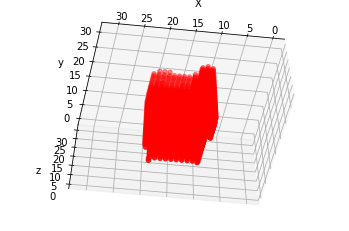

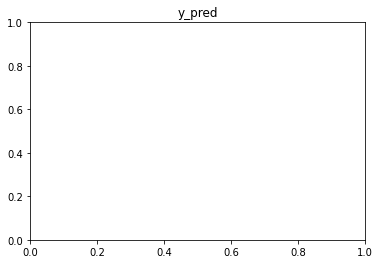

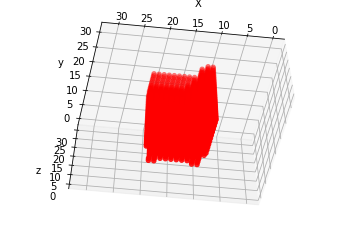

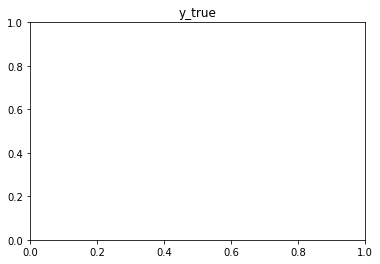

In [6]:
# Prediction
sys.path.append('..')
GPU='0'

def load_rgbs(test_mv=3):
    obj_rgbs_folder = '/content/drive/MyDrive/AttSets-master/Data_sample/Dataset/03001627/1a38407b3036795d19fb4103277a6b93/rendering/'
    obj_gt_vox_path ='/content/drive/MyDrive/AttSets-master/Data_sample/Original_3D_model/03001627/1a38407b3036795d19fb4103277a6b93/model.binvox'
    rgbs=[]
    rgbs_views = sorted(os.listdir(obj_rgbs_folder))
    for v in rgbs_views:
        if not v.endswith('png'): continue
        rgbs.append(tools.Data.load_single_X_rgb_r2n2(obj_rgbs_folder + v, train=False))
    rgbs = np.asarray(rgbs)
    x_sample = rgbs[0:test_mv, :, :, :].reshape(1, test_mv, 127, 127, 3)
    y_true = tools.Data.load_single_Y_vox(obj_gt_vox_path)
    return x_sample, y_true

def ttest_demo():
    model_path = '/content/drive/MyDrive/AttSets-master/Model_released/'
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.visible_device_list = GPU
    with tf.Session(config=config) as sess:
        saver = tf.train.import_meta_graph(model_path + 'model.cptk.meta', clear_devices=True)
        saver.restore(sess, model_path + 'model.cptk')
        print ('model restored!')

        X = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
        Y_pred = tf.get_default_graph().get_tensor_by_name("r2n/Reshape_7:0")
        print(X)

        
        x_sample, gt_vox = load_rgbs()
      
        print(Y_pred)
        y_pred = sess.run(Y_pred, feed_dict={X: x_sample})

    # plotting the result
    th = 0.25
    print(y_pred.shape)
    y_pred[y_pred>=th]=1
    y_pred[y_pred<th]=0
    tools.Data.plotFromVoxels(np.reshape(y_pred,[32,32,32]), title='y_pred')
    if gt_vox is not None:
        tools.Data.plotFromVoxels(np.reshape(gt_vox,[32,32,32]), title='y_true')
    from matplotlib.pyplot import show
    show()


if __name__ == '__main__':
    ttest_demo()